<a href="https://colab.research.google.com/github/embarced/notebooks/blob/master/deep/intro-regression-2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regression

_Can we approximate the relation between two variables with a function learned by training from known data_?

_Objective: predict missing or unknown data points_

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 8)
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 20

figsize_3d = (20, 10)

# Part I: The use case and data

## We begin with a plot of a dependent variable

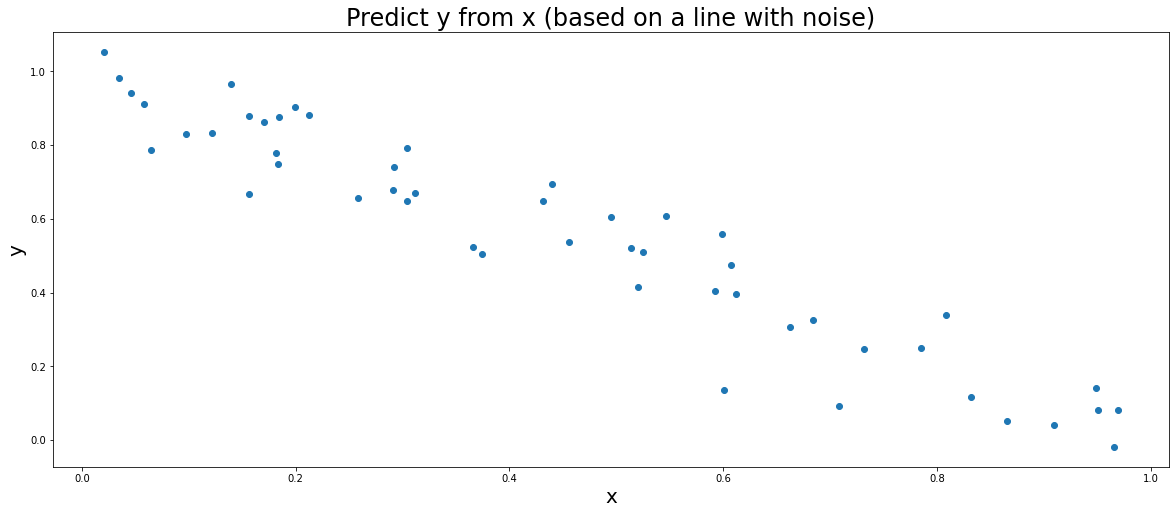

In [ ]:
#@title A noisy line of shape y = m*x + b { run: "auto", display-mode: "form" }

# https://colab.research.google.com/notebooks/forms.ipynb

n = 50 #@param {type:"slider", min:10, max:500, step:1}
m = -1 #@param {type:"slider", min:-10, max:10, step: 0.1}
b = 1 #@param {type:"slider", min:-10, max:10, step: 0.1}

noise_level = 0.1 #@param {type:"slider", min:0.0, max:1.0, step:0.1}

title = 'Predict y from x (based on a line with noise)' #@param {type:"string"}
x_label = 'x' #@param {type:"string"}
y_label = 'y' #@param {type:"string"}

import numpy as np
np.random.seed(42)

# sort is not necessary, but makes x easier to understand
x = np.sort(np.random.uniform(0, 1, n))
y = m*x+b + np.random.normal(0, noise_level, n)

plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title(title)

plt.scatter(x, y);

## _Challenge: How do we fit the best line possible?_

* Maybe to predict the future or missing data
* Or understand the nature of the data

_Having a **line** is our prior believe, we will later remove this assumption_ 

### ```y = m*x + b```

* `m` is the slope 
* `b` is the y-intercept


# Part II: Use a single neuron to model a linear function

1. Model the linear function with a fully connected layer
2. Use a standard loss function
3. Finding parameters to tune
4. Changing parameters

In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
tf.__version__

'2.7.0'

In [ ]:
tf.random.set_seed(42)

## Step 1: use a dense layer having a single neuron
* Scales well for as many neurons and inputs as we want
* Remember: for now we are assuming a line, but this is a prior that might not be necessary
* Efficient implementation on GPUs



### The Artificial Neuron: Foundation of Deep Neural Networks (simplified, more later)

<img src='https://djcordhose.github.io/ml-workshop/img/neuron-v2.png'>

### Defining a dense layer with a random number of neurons and inputs

<img src='https://github.com/DJCordhose/ml-workshop/blob/master/notebooks/tf-intro/neuron-to-layer.png?raw=1'>



In [ ]:
from tensorflow.keras.layers import Dense
 
model = tf.keras.Sequential([
  Dense(units=1, input_dim=1)
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [ ]:
kernel, bias = model.trainable_variables
kernel.value(), bias.value

(<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.65087426]], dtype=float32)>,
 10)

In [ ]:
x_tensor = tf.expand_dims(tf.constant(x, dtype=tf.float32), axis=1)
y_tensor = tf.expand_dims(tf.constant(y, dtype=tf.float32), axis=1)
x_tensor.shape

TensorShape([50, 1])

In [ ]:
y_pred = model(x_tensor)
# y_pred

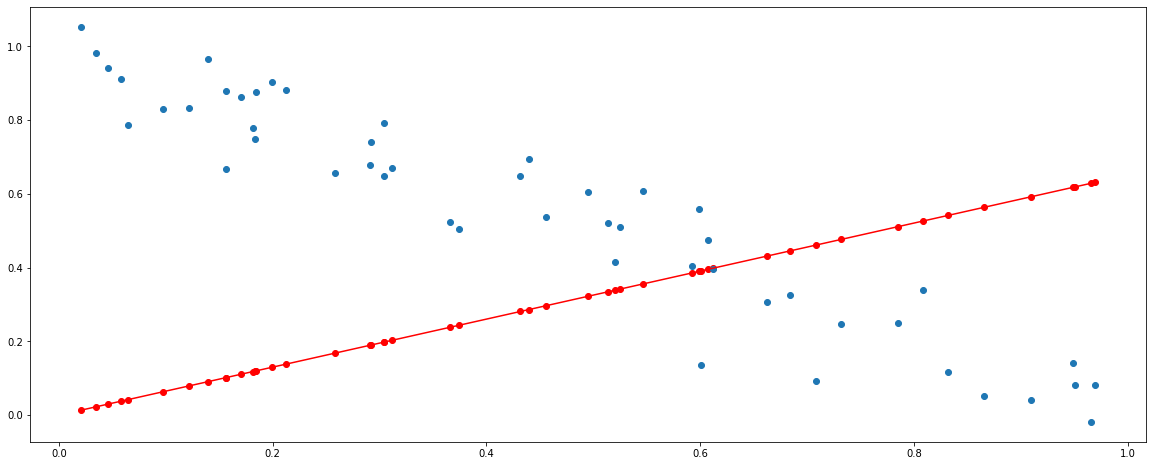

In [ ]:
plt.plot(x, y_pred, color='r')
plt.scatter(x, y_pred, color='r')
plt.scatter(x, y);

## Step 2: use standard loss and metric 
* we know we are wrong, but by how much?
* we need to measure how wrong we are to have something to optimize for
* mean squared error is very common, it squares the differences and gives high values a larger weight: mse


### Mean Squared Error

emphasizes larger errors

$MSE = {\frac {1}{n}}\sum _{i=1}^{n}(Y_{i}-{\hat {Y_{i}}})^{2}$


https://en.wikipedia.org/wiki/Mean_squared_error


In [ ]:
tf.losses.mean_squared_error(y_true=tf.squeeze(y_tensor), y_pred=tf.squeeze(y_pred)).numpy()

5.499152

### Looking at the loss surface for our problem

(-0.9999999999999991, 1.0000000000000027)

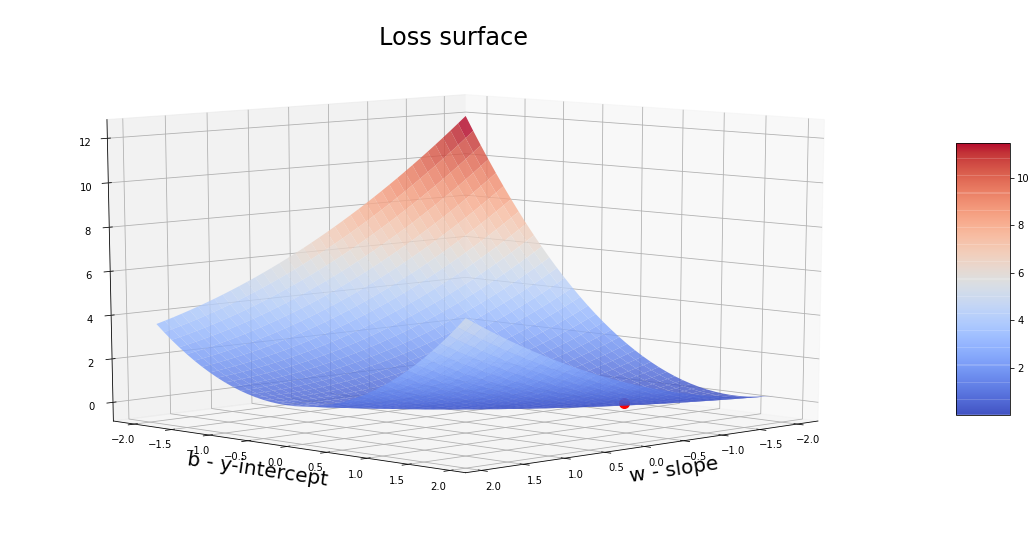

In [ ]:
step = 0.1
w_space = np.arange(-2, 2, step)
b_space = np.arange(-2, 2, step)

sample_size = len(w_space)
losses = np.zeros((sample_size, sample_size))

min_loss = float('inf')
min_params = None

for wi in range(sample_size):
  for bi in range(sample_size):
      model.trainable_weights[0].assign(w_space[wi].reshape(1, 1))
      model.trainable_weights[1].assign(b_space[bi].reshape(1, ))

      y_pred = model(x_tensor)
      loss = tf.losses.mean_squared_error(y_true=tf.squeeze(y_tensor), y_pred=tf.squeeze(y_pred)).numpy()
      if loss < min_loss:
        min_loss = loss
        min_params = (w_space[wi], b_space[bi])
      # the order seems weird, but aparently this is what the 3d plot expects  
      losses[bi, wi] = loss

# min_loss, min_params

# https://matplotlib.org/mpl_toolkits/mplot3d/tutorial.html
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure(figsize=figsize_3d)
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Loss surface')

W, B = np.meshgrid(w_space, b_space)

# ax.plot_wireframe(W, B, losses)
surf = ax.plot_surface(W, B, losses, cmap=cm.coolwarm, 
                      #  linewidth=0, 
                       alpha=0.8,
                      #  antialiased=False
                       )
fig.colorbar(surf, shrink=0.5, aspect=5)

ax.set_xlabel('w - slope')
ax.set_ylabel('b - y-intercept')

ax.scatter(min_params[0], min_params[1], min_loss, s=100, color='r')

# https://en.wikipedia.org/wiki/Azimuth
# ax.view_init(elev=30, azim=-60); # default
# ax.view_init(elev=50, azim=60);
ax.view_init(elev=10, azim=45);

min_params[0], min_params[1]

### R2 Metric: MSE and MAE are not speaking

* Loss functions need to be differentiable
* This often restricts how speaking they are in terms of business value
* Metrics do not have that resriction, but take the same parameters
* R^2 score, the closer to 1 the better
* loosely speaking: how much better is this than predicting the constant mean
* 0 would mean just as good
* 1 is perfect
* neg. would mean even worse
* it can become arbitrarily worse

In [ ]:
# https://keras.io/metrics/#custom-metrics
# https://www.tensorflow.org/tutorials/customization/performance
  
# ported to TF 2 from 
# * https://stackoverflow.com/a/42351397/1756489 and
# * https://www.kaggle.com/c/mercedes-benz-greener-manufacturing/discussion/34019 (for use of epsilon to avoid strange inf or -inf)

# only works properly on tensors

@tf.function
def r2_metric(y_true, y_pred):
  total_error = tf.reduce_sum(tf.square(tf.subtract(y_true, tf.reduce_mean(y_true))))
  unexplained_error = tf.reduce_sum(tf.square(tf.subtract(y_true, y_pred)))
  R_squared = tf.subtract(1.0, tf.divide(unexplained_error, tf.add(total_error, tf.keras.backend.epsilon())))
  
  return R_squared

In [ ]:
r2_metric(y_true=tf.squeeze(y_tensor), y_pred=tf.squeeze(y_pred)).numpy()

-62.056526

## Step 3: Finding parameters to tune
 * doing a full grid search is expensive and only works for very few dimensions with a clear domain of values
* why not slide down the slope of the loss function down to the minimum?
* this is what we do in deep learning


### Backpropagation algorithm: The core of how a neural network learns

_In a nutshell:_
1. Predict: Let the network make a prediction 
1. Calculate the loss: how accurate was the predition
1. Record a function of how the trainable parameters affect the loss 
1. partial derivations: find out in which direction to change all parameters to bring down the loss
1. Optimizer: Make changes to parameters based on learning rate and other parameters


### For this we need partial derivations

TensorFlow offers automatic differentiation: https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/GradientTape

* tape will record operations for automatic differentiation
* either by making it record explicily (watch) or 
* by declaring a varible to be trainable (which we did in the layer above) 



In [ ]:
from tensorflow import GradientTape 
# GradientTape?

In [ ]:
def tape_sample():
  x = tf.Variable(3.0)
  with tf.GradientTape() as tape:
    y = x * x
  print("x: {}, y:{}".format(x.numpy(), y.numpy()))
  # how is y dependending on x
  dy_dx = tape.gradient(y, x)
  print("dy/dx: {}".format(dy_dx.numpy()))
  
# just a function in order not to interfere with x on the global scope  
tape_sample()

## Step 4: Intermediate solution: applying all this to our training loop

In [ ]:
%%time

model = tf.keras.Sequential([
  Dense(units=1, input_dim=1)
])

EPOCHS = 1500
learning_rate = 0.01

losses = []
r2s = []

for step in range(EPOCHS):
  with tf.GradientTape() as tape:

    # forward pass, all data
    # often we do not use all data to calculate the loss, but only a certain fraction, called the batch
    # you could also push data through one by one, being an extreme version of a batched approached
    # in our case we use all the data we have and calculate the combined error
    y_pred = model(x_tensor)

    # loss for this batch
    loss = tf.losses.mean_squared_error(y_true=tf.squeeze(y_tensor), y_pred=tf.squeeze(y_pred))
    
  # just for logging
  losses.append(loss)
  
  # metrics
  r2s.append(r2_metric(y_true=tf.squeeze(y_tensor), y_pred=tf.squeeze(y_pred)))

  # get gradients of weights wrt the loss
  # as we have two weights, we get two gradients
  (dw, db) = tape.gradient(loss, model.trainable_weights)
  
  # optimizer: backward pass, changing trainable weights in the direction of the mimimum
  model.trainable_weights[0].assign_sub(learning_rate * dw)
  model.trainable_weights[1].assign_sub(learning_rate * db)

CPU times: user 4.04 s, sys: 51.6 ms, total: 4.09 s
Wall time: 4.03 s


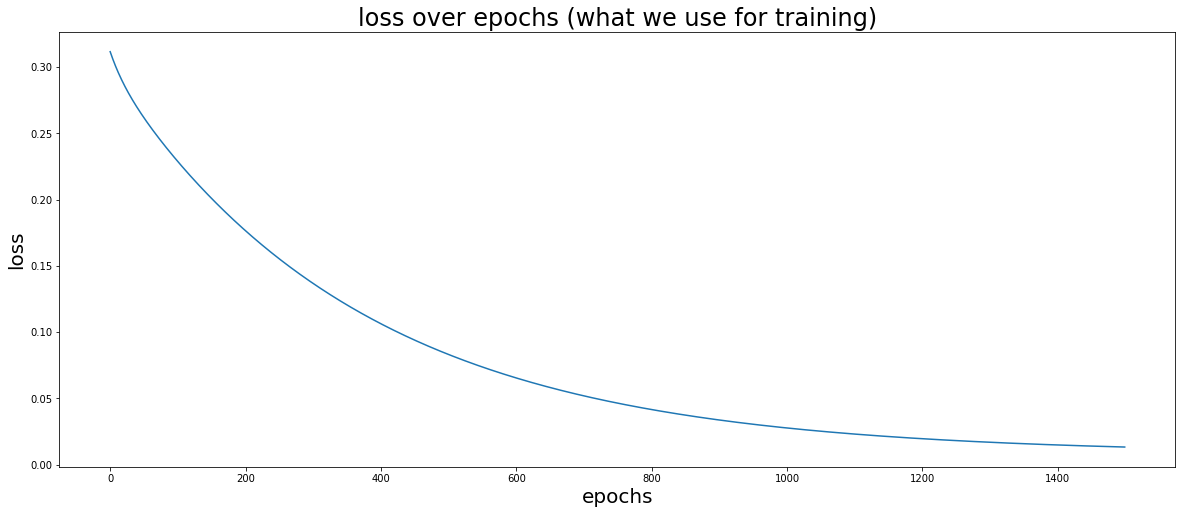

In [ ]:
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('loss over epochs (what we use for training)')

# plt.yscale('log')

plt.plot(losses);

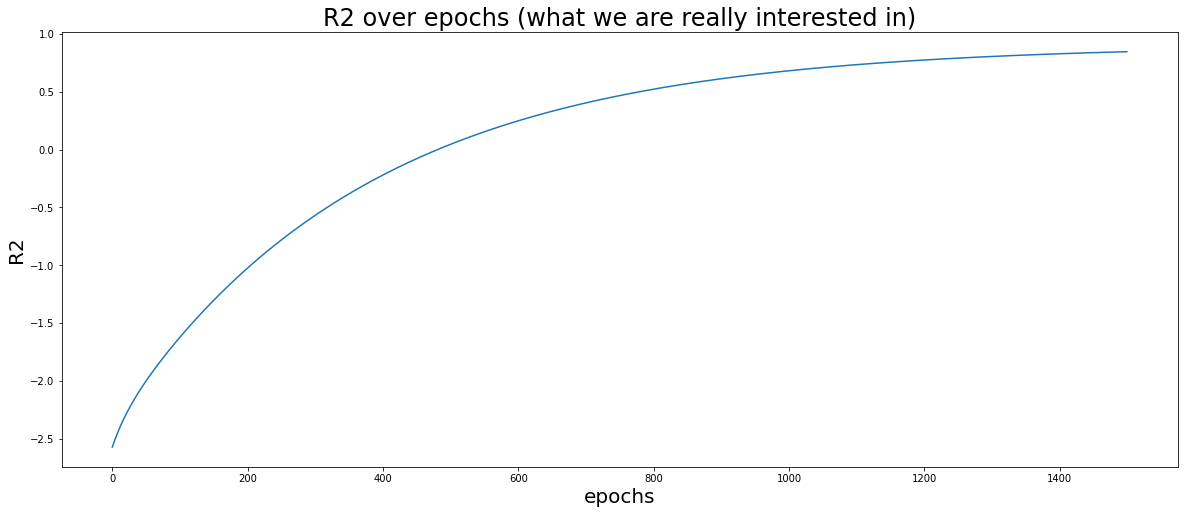

In [ ]:
plt.xlabel('epochs')
plt.ylabel('R2')
plt.title('R2 over epochs (what we are really interested in)')

plt.plot(r2s);

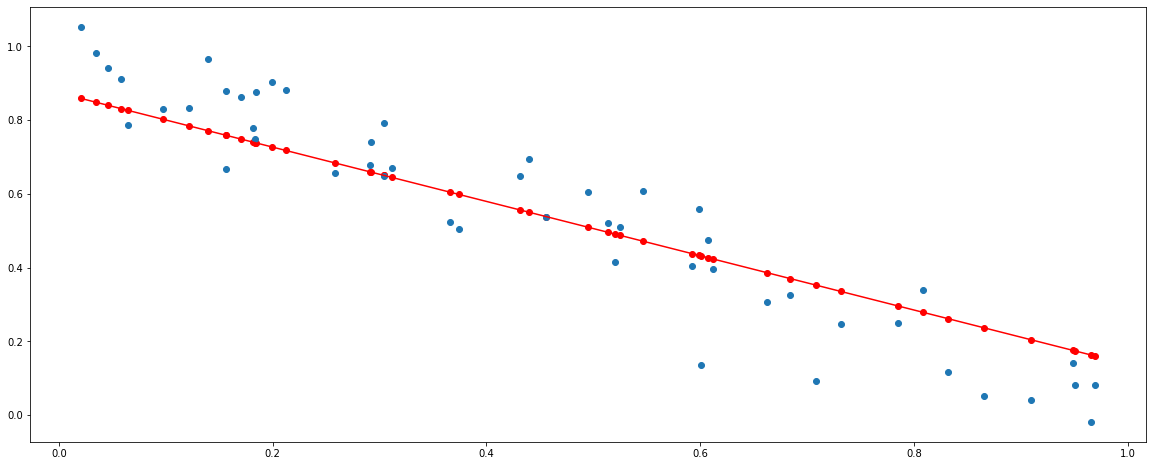

In [ ]:
y_pred = model(x_tensor)
plt.plot(x, y_pred, color='r')
plt.scatter(x, y_pred, color='r')
plt.scatter(x, y);

## Step 5: Smarter changing of parameters

#### SGD: (Stochastic) Gradient Descent

_w = w - learning_rate * g_

https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD

_Note: to make this stochastic it would require us to split our training data into batches and shuffle after each epoch_

### We are already doing this, but prebuilt Optimizers do this job more flexible and with a standard API



In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2)

In [ ]:
%%time

model = tf.keras.Sequential([
  Dense(units=1, input_dim=1)
])

EPOCHS = 1500

losses = []
r2s = []

for step in range(EPOCHS):
  with tf.GradientTape() as tape:

    # forward pass, all data
    y_pred = model(x_tensor)

    # loss for this batch
    loss = tf.losses.mean_squared_error(y_true=tf.squeeze(y_tensor), y_pred=tf.squeeze(y_pred))
    
  # just for logging
  losses.append(loss)
  
  # metrics
  r2s.append(r2_metric(y_true=tf.squeeze(y_tensor), y_pred=tf.squeeze(y_pred)))

  # Get gradients of weights wrt the loss.
  gradients = tape.gradient(loss, model.trainable_weights)
  
  # Update the weights of our linear layer.
  optimizer.apply_gradients(zip(gradients, model.trainable_weights))

CPU times: user 5.17 s, sys: 57.8 ms, total: 5.22 s
Wall time: 5.14 s


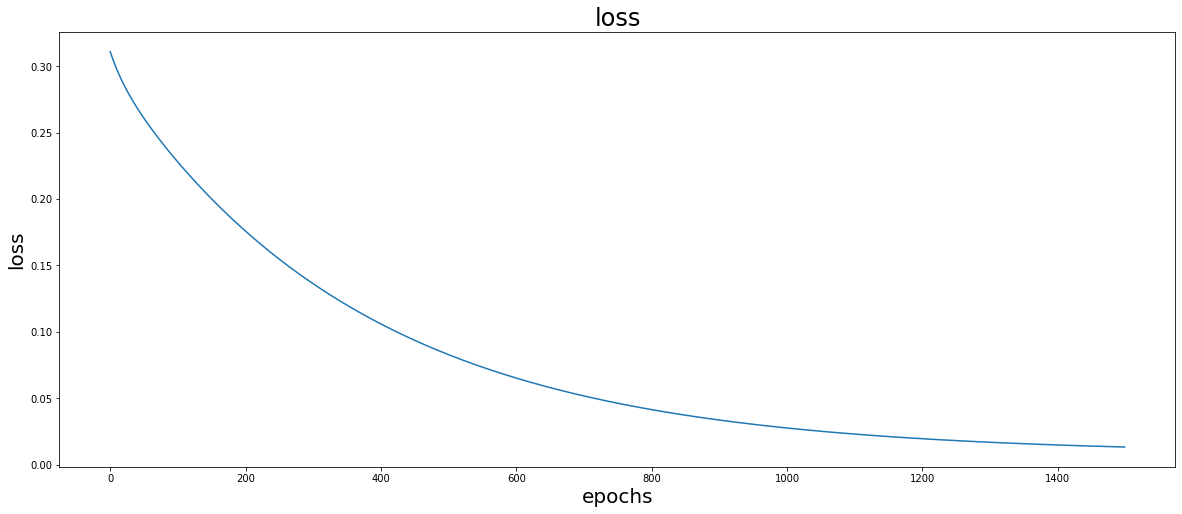

In [ ]:
# plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title('loss')

plt.plot(losses);

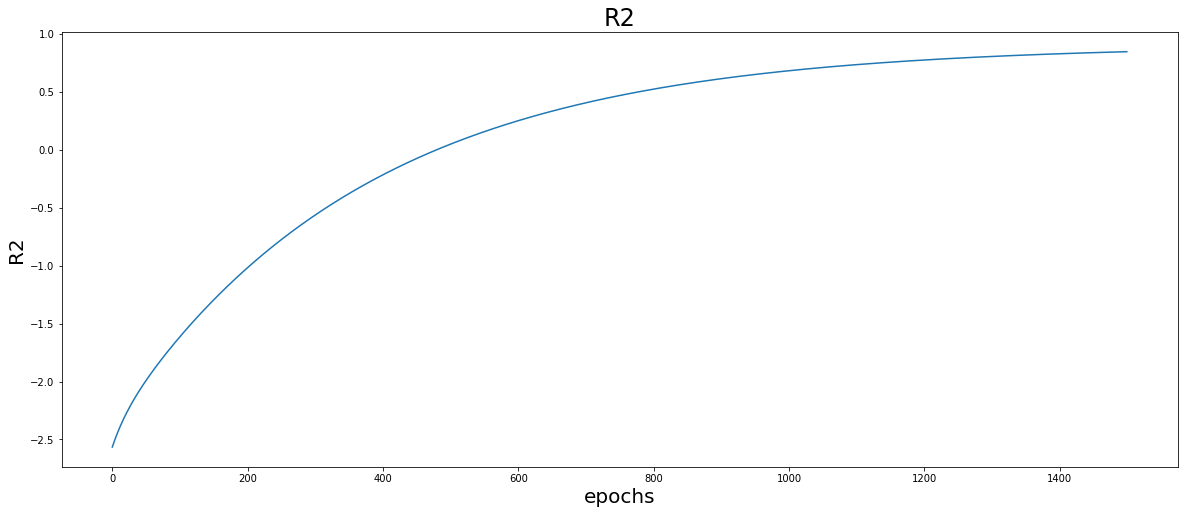

In [ ]:
plt.xlabel('epochs')
plt.ylabel('R2')
plt.title('R2')

plt.plot(r2s);

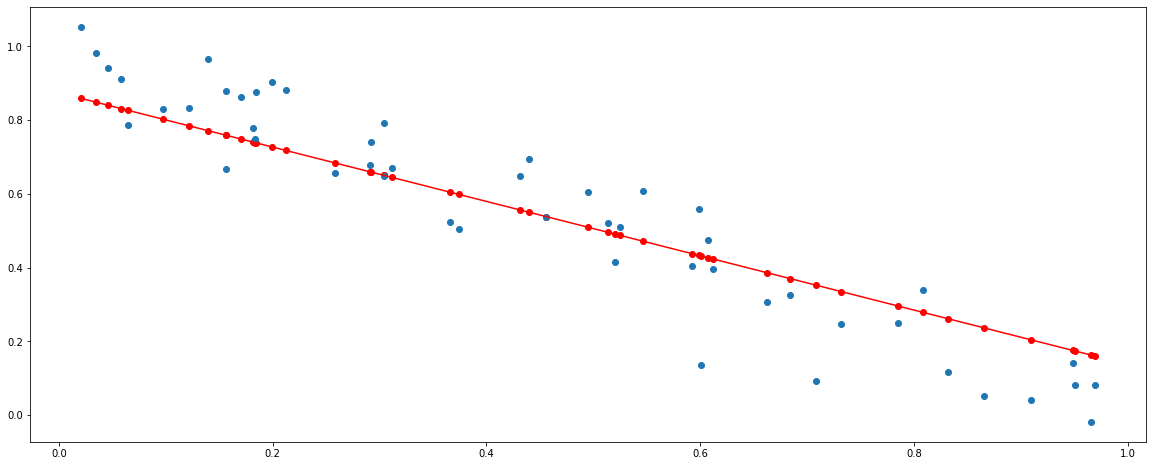

In [ ]:
y_pred = model(x_tensor)
plt.plot(x, y_pred, color='r')
plt.scatter(x, y_pred, color='r')
plt.scatter(x, y);

# Part III: The same solution using high level Keas API

## Keras vs TensorFlow

<img src='https://djcordhose.github.io/ml-workshop/img/tf-vs-keras.png'>

https://twitter.com/fchollet at http://scaledml.org/2020/

In [ ]:
from tensorflow.keras.layers import Dense
 
model = tf.keras.Sequential([
  Dense(units=1, input_dim=1)                   
])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%%time 

model.compile(loss=tf.losses.mean_squared_error, # mean squared error, unchanged from low level example
             optimizer=tf.keras.optimizers.SGD(learning_rate=1e-2), # SGD, unchanged from low level example
             metrics=[r2_metric]) # we can track the r2 metric over time

# does a similar thing internally as our loop from above
history = model.fit(x, y, epochs=1000, verbose=0)

CPU times: user 3.83 s, sys: 245 ms, total: 4.07 s
Wall time: 3.38 s


In [ ]:
loss, r2 = model.evaluate(x, y, verbose=0)
loss, r2

(0.00981919839978218, 0.594458281993866)

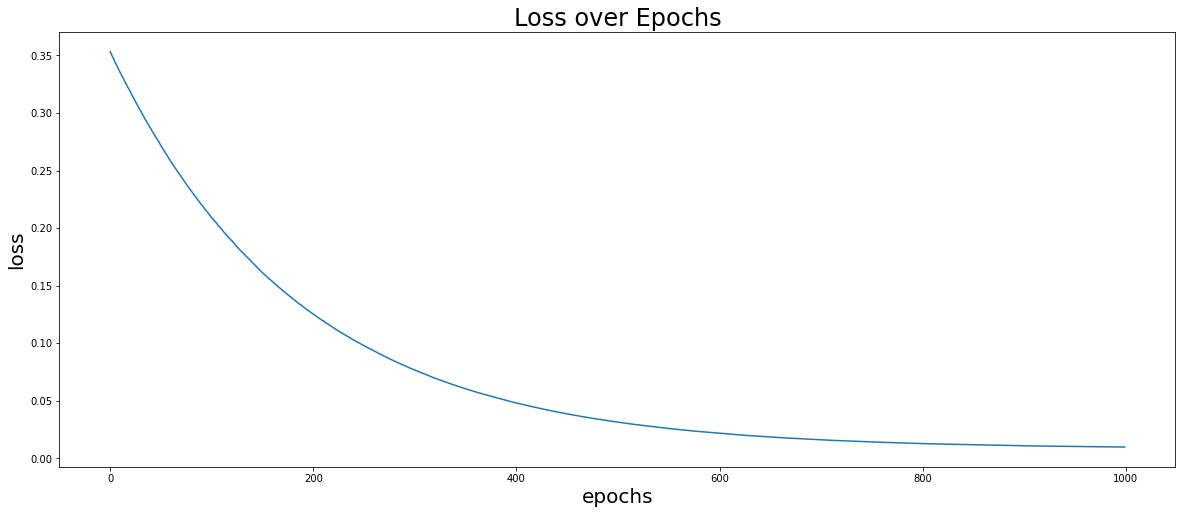

In [ ]:
# plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title('Loss over Epochs')

plt.plot(history.history['loss']);

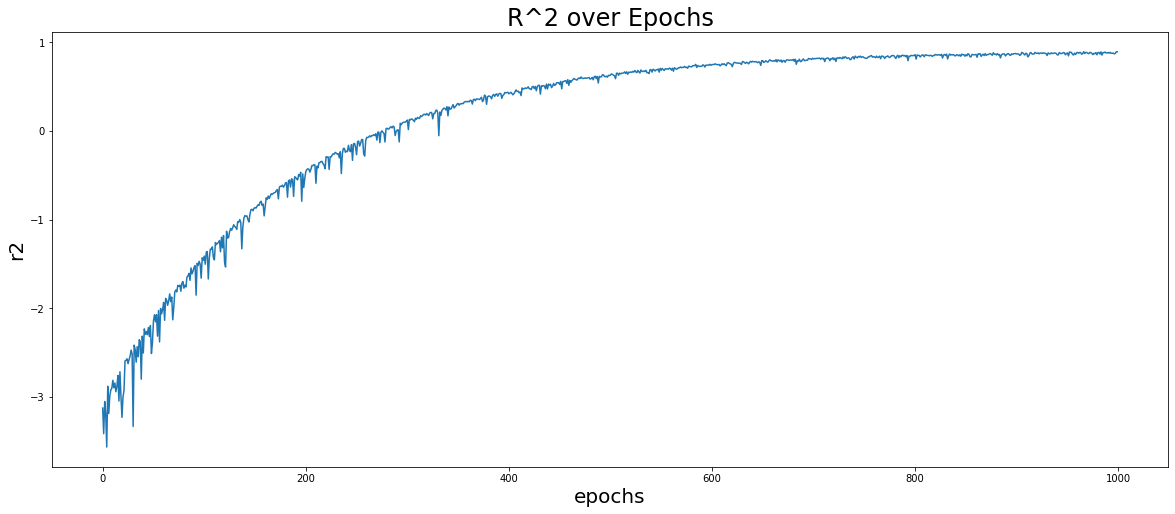

In [ ]:
plt.ylabel("r2")
plt.xlabel("epochs")
plt.title('R^2 over Epochs')
# plt.yscale('log')

plt.plot(history.history['r2_metric']);

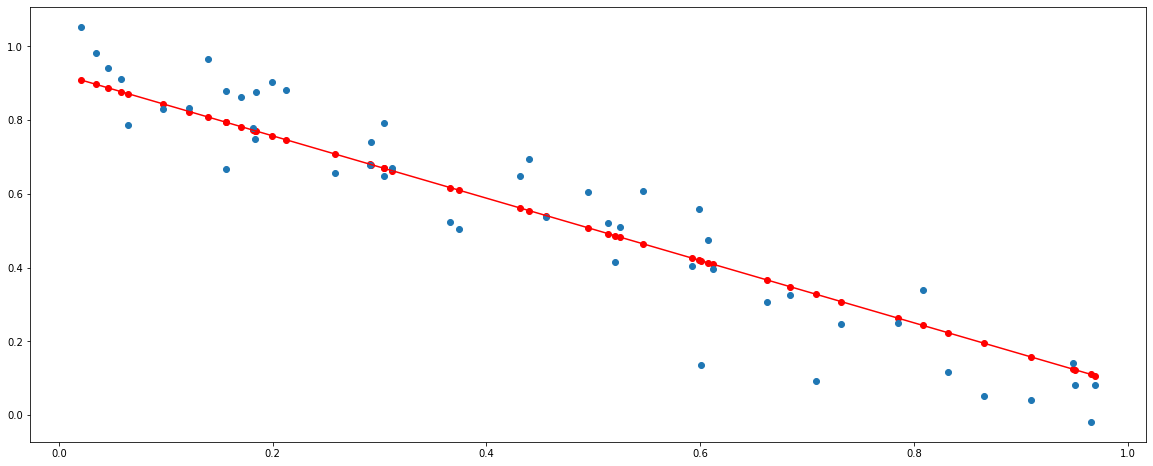

In [ ]:
y_pred = model.predict(x)
plt.plot(x, y_pred, color='red')
plt.scatter(x, y_pred, color='red')
plt.scatter(x, y);

# Hands-On: Fitting arbitrary data

## Choose between three options

1. Adapt the existing example by changing slope, adding noise etc.
1. Use the generator to create a noisy sine wave or any other function
1. Draw something by hand
   * depending on complexity of function might requriw a lot tweaking
   * so might be tricky, as hard as it gets
   * it is likely you will fail, but you will see more powerful approaches later

## Challenges
* do you get good results, if not, why not? what would you need to get better results?
* extend the area of prediction to something off the bounds of the training data
* have a look at this Twitter thread on when and why results might be questionable: https://twitter.com/fchollet/status/1450871559803916290

## Option 1: Adapt original example

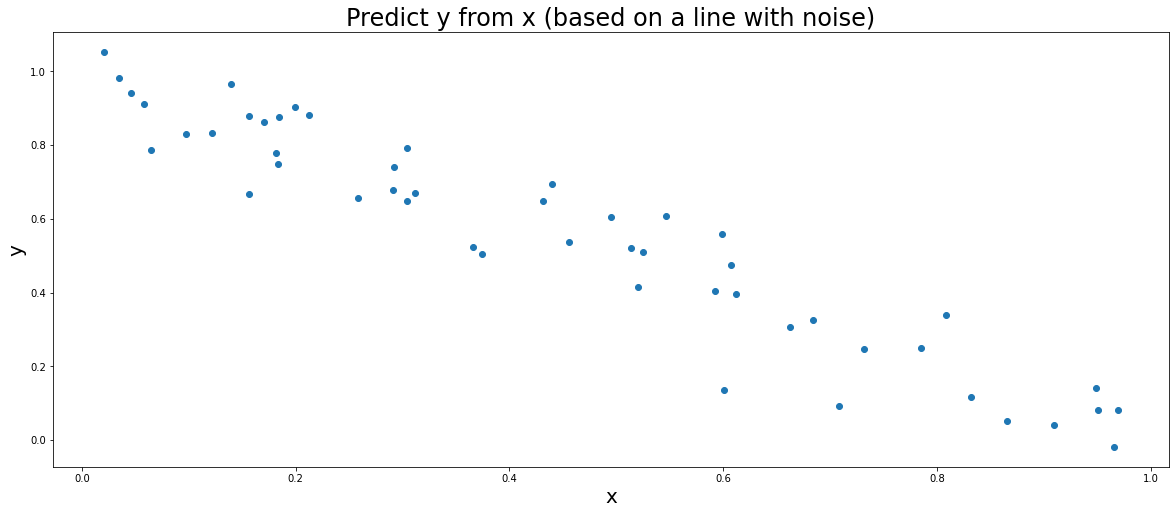

In [ ]:
#@title A noisy line of shape y = m*x + b { run: "auto", display-mode: "form" }

# https://colab.research.google.com/notebooks/forms.ipynb

n = 50 #@param {type:"slider", min:10, max:500, step:1}
m = -1 #@param {type:"slider", min:-10, max:10, step: 0.1}
b = 1 #@param {type:"slider", min:-10, max:10, step: 0.1}

noise_level = 0.1 #@param {type:"slider", min:0.0, max:1.0, step:0.1}

title = 'Predict y from x (based on a line with noise)' #@param {type:"string"}
x_label = 'x' #@param {type:"string"}
y_label = 'y' #@param {type:"string"}

import numpy as np
np.random.seed(42)

# sort is not necessary, but makes x easier to understand
x = np.sort(np.random.uniform(0, 1, n))
y = m*x+b + np.random.normal(0, noise_level, n)

plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title(title)

plt.scatter(x, y);

In [ ]:
x_tensor = tf.expand_dims(tf.constant(x, dtype=tf.float32), axis=1)
y_tensor = tf.expand_dims(tf.constant(y, dtype=tf.float32), axis=1)

In [ ]:
# your code goes here

## Option 2: Generate data from non linear function

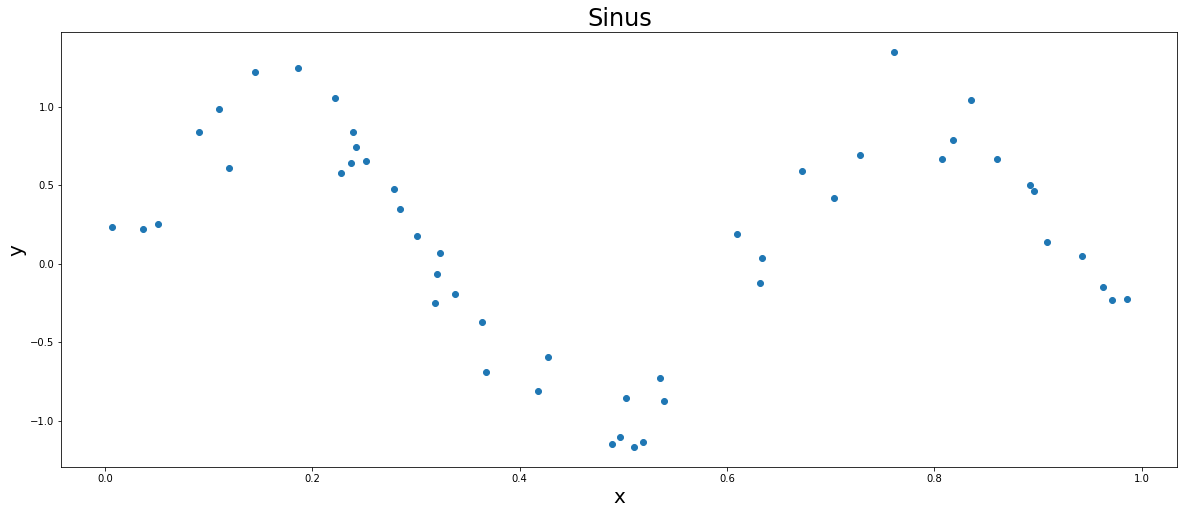

In [ ]:
#@title A noisy sine curve { run: "auto", display-mode: "form" }

n = 50 #@param {type:"slider", min:10, max:500, step:1}
noise_level = 0.2 #@param {type:"slider", min:0.1, max:1.0, step:0.1}
scale = 10 #@param {type:"slider", min:1, max:100, step:1}

import numpy as np

x = np.random.uniform(0, 1, n)
y = np.sin(x*scale) + np.random.normal(0, noise_level, n)

plt.xlabel('x')
plt.ylabel('y')
plt.title('Sinus')

plt.scatter(x, y);

In [ ]:
x_tensor = tf.expand_dims(tf.constant(x, dtype=tf.float32), axis=1)
y_tensor = tf.expand_dims(tf.constant(y, dtype=tf.float32), axis=1)

In [ ]:
# your code goes here

## Option 3: Fitting hand drawn data 

* https://twitter.com/fishnets88/status/1383333912470974470
* https://calmcode.io/labs/drawdata.html
* https://github.com/koaning/drawdata

In [ ]:
 !pip install -q drawdata

     |████████████████████████████████| 792 kB 7.8 MB/s 
     |████████████████████████████████| 374 kB 42.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipython~=5.5.0, but you have ipython 7.31.1 which is incompatible.


In [ ]:
from drawdata import draw_line, draw_scatter, draw_histogram

draw_line()

In [ ]:
# COPY CSV AND MANUALLY PASTE CSV DATA INSIDE QUOTED BLOCK

drawdata_data = """
"""

In [ ]:
from io import StringIO
import pandas as pd

df = pd.read_csv(StringIO(drawdata_data))
df.head()

,x,y,z
0,48,124,a
1,48,125,a
2,49,127,a
3,49,129,a
4,50,131,a


In [ ]:
x = df['x']
y = df['y']

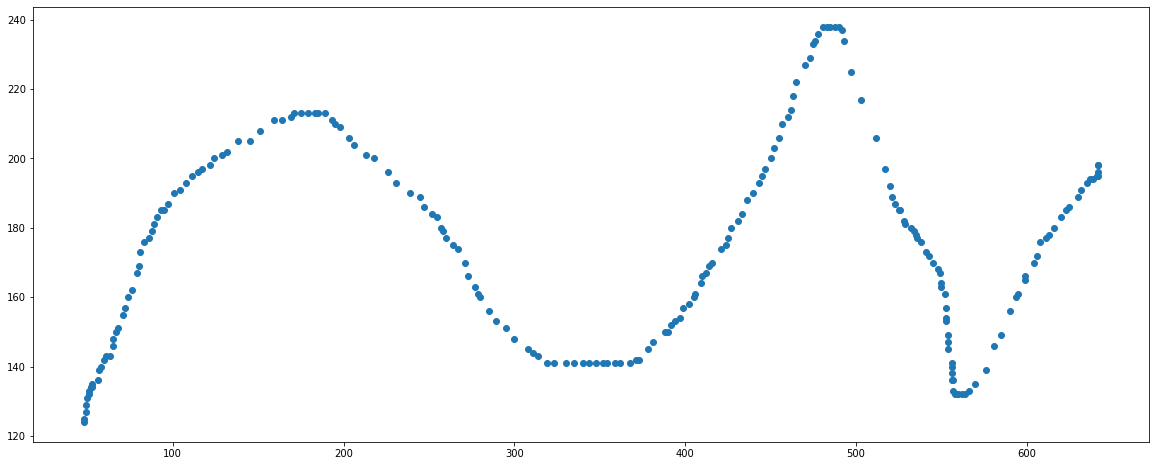

In [ ]:
plt.scatter(x, y);

In [ ]:
x_tensor = tf.expand_dims(tf.constant(x, dtype=tf.float32), axis=1)
y_tensor = tf.expand_dims(tf.constant(y, dtype=tf.float32), axis=1)

In [ ]:
# your code goes here